In [20]:
import string
from sklearn.decomposition import NMF
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from nltk.corpus import wordnet
import nltk
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from tqdm import tqdm

nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/niklasz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
### Configuration ###
file_name = 'data.csv'
seed = 42
np.random.seed(seed)
random.seed(seed)

In [3]:
df = pd.read_csv(file_name)
df.head()

,full_text,summary,keywords,publish_date,authors,url,leaf_label,root_label
0,"'Pure Hockey, the largest hockey retailer in t...","'Pure Hockey, the largest hockey retailer in t...","['acquire', 'agrees', 'nevada', 'retail', 'hoc...",2022-10-21 17:11:22+00:00,['Ein News'],https://www.einnews.com/pr_news/597148062/pure...,hockey,sports
1,'HKO Hockey Canada Sponsorship 20221006\n\nHoc...,'The tally of Hockey Canada’s sponsorship loss...,"['sexual', 'exclusive', 'settlement', 'million...",NaN,['Barbara Shecter'],https://ca.finance.yahoo.com/news/exclusive-ho...,hockey,sports
2,'Canadian Prime Minister Justin Trudeau said W...,'Canadian Prime Minister Justin Trudeau said W...,"['québec', 'surprise', 'trust', 'sexual', 'org...",2022-10-05 00:00:00,['The Athletic Staff'],https://theathletic.com/3659888/2022/10/05/hoc...,hockey,sports
3,'Hockey Canada paid a crisis communications fi...,'Nicholson says that Hockey Canada did not go ...,"['sexual', 'organization', 'million', 'ceo', '...",2022-11-15 00:00:00,['Dan Robson'],https://theathletic.com/3900630/2022/11/15/hoc...,hockey,sports
4,'The Denver Broncos are looking for a new head...,'The Denver Broncos are looking for a new head...,"['beats', 'force', 'season', 'teams', 'anchora...",NaN,"['Parker Seibold', 'The Gazette', 'Gazette File']",https://gazette.com/multimedia/photo-air-force...,hockey,sports


In [4]:
### Clean-ups ###
# Fix "%22forest%20fire%22" class label
df['leaf_label'] = df.apply(lambda row: row['leaf_label'].strip('%22').replace('%20', ' '), axis=1)

# Question 1

## 1.1 - Samples and Features in dataset

In [5]:
no_samples, no_features = df.shape
print(f'The dataset has {no_samples} samples and {no_features} features')

The dataset has 3150 samples and 8 features


Text(0.5, 1.0, "Alpha-numeric character counts in 'full_text' with 100 bins")

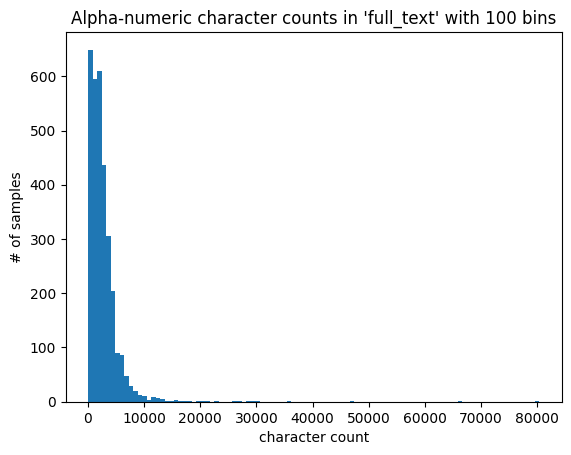

In [6]:
### Histogram - alphanumeric ###
name = 'full_text'


def count_alphanumeric(row):
    alphanumeric_str = re.sub(r'[^a-zA-Z0-9]', '', row[name])
    row['alphanumeric_count'] = len(alphanumeric_str)
    return row


df_alphanumeric = df.apply(count_alphanumeric, axis=1)
bin_count = 100
plt.hist(df_alphanumeric['alphanumeric_count'], bins=bin_count)
plt.xlabel('character count')
plt.ylabel('# of samples')
plt.title(f"Alpha-numeric character counts in '{name}' with {bin_count} bins")

Text(0.5, 1.0, "Class distribution of 'leaf_label'")

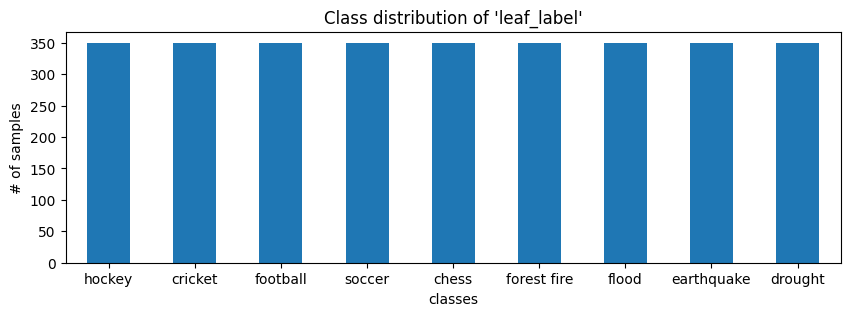

In [7]:
### Histogram - leaf_label ###
name = 'leaf_label'
leaf_label_counts = df[name].value_counts()

plt.figure(figsize=(10, 3))
leaf_label_counts.plot.bar(x='lab', y='val', rot=0)
plt.xlabel('classes')
plt.ylabel('# of samples')
plt.title(f"Class distribution of '{name}'")

Text(0.5, 1.0, "Class distribution of 'root_label'")

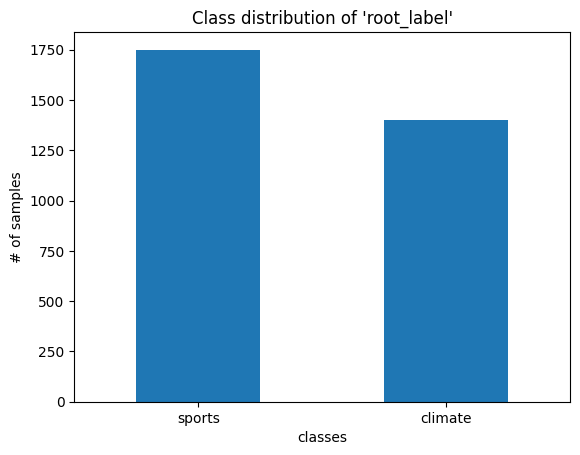

In [8]:
### Histogram - root_label ###
name = 'root_label'
root_label_counts = df[name].value_counts()

root_label_counts.plot.bar(x='lab', y='val', rot=0)
plt.xlabel('classes')
plt.ylabel('# of samples')
plt.title(f"Class distribution of '{name}'")

## 1.3 Qualitative Analysis
1. As alphanumeric characters likely make up the bulk of each document, this histogram gives us a sense of how the size of documents are distributed. We can see that the vast majority is < 10000 characters with a few large outliers in the 10000-80000 range.
2. There are 9 classes in among the leaf labels and they are uniformly distributed among the samples, which is convenient as this means we may not need to resample or augment the data to train a classifier.
3. There are 2 classes among the root labels and that the distribution is uneven (~56% sports, ~44% climate). This means we may need to augment climate samples or drop the least valuable sports samples. Alternatively, any classifier needs to be > 56% accurate to be better to be meaningful.

# Question 2

In [9]:
### Sample counts ###
train, test = train_test_split(df[["full_text", "root_label"]], test_size=0.2, random_state=seed)
print(f'There are {len(train)} train and {len(test)} test samples')

There are 2520 train and 630 test samples


# Question 3

In [10]:
def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"", texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u ', " you ", texter)
    texter = re.sub('`', "", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ', texter)
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
        texter = ""
    return texter


def corpus_size(corpus: np.ndarray):
    return np.vectorize(len)(corpus).sum()

## 3.1 - TF-IDF Generation

In [11]:
### Feature Extraction ###

# Taken from https://stackoverflow.com/questions/15586721/wordnet-lemmatization-and-pos-tagging-in-python
def map_pos_to_wordnet(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        # This is the default used by WordNet if no POS tag is given, so we may as well return it here.
        return wordnet.NOUN


lemmatizer = WordNetLemmatizer()
detokeniser = TreebankWordDetokenizer()
number_regex = re.compile(r'^-?\d+(\.\d+)?$')


def lemmatize(text):
    tokens = nltk.word_tokenize(text)
    tagged_tokens = nltk.pos_tag(tokens)
    lemmatized_tokens = [lemmatizer.lemmatize(t.lower(), pos=map_pos_to_wordnet(tag)) for t, tag in tagged_tokens]
    filtered_punctuation = [t for t in lemmatized_tokens if t not in """!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""]
    filtered_numbers = [t for t in filtered_punctuation if not bool(number_regex.search(t))]
    return detokeniser.detokenize(filtered_numbers)


def prepare_corpus(corpus):
    cleaned_corpus = np.vectorize(clean)(corpus)
    lemmatized_corpus = np.vectorize(lemmatize)(cleaned_corpus)
    return lemmatized_corpus


train_lemmatized = prepare_corpus(train['full_text'])
test_lemmatized = prepare_corpus(test['full_text'])

vectorizer = TfidfVectorizer(stop_words='english', min_df=3)
train_tf_idf = vectorizer.fit_transform(train_lemmatized)
names = vectorizer.get_feature_names_out()
test_tf_idf = vectorizer.transform(test_lemmatized)

## 3.2 - What are the pros and cons of lemmatisation versus stemming?
Stemming algorithms use heuristics that remove prefixes and suffixes from words to simplify them down to a base form. Lemmatisation performs a part-of-speech (POS) tagging and morphological analysis to reduce words down their base form. Both have the purpose of simplifying a text for downstream tasks.

Stemming is easiest to implement for a new language as it does not require a dictionary of words and POS tagger that understands the language's grammar. It is also computationally cheaper than lemmatisation. The resulting dictionary of words is smaller, but less precise.

Lemmatisaton requires the aforementioned additional structures for a language and is computationally more expensive to run on a corpus. The resulting dictionary is larger and more precise.s

Here is a comparison of the NLTK Porter Stemmer and WordNet Lemmatizer:

- Input: "I attained universal knowledge of the universe at university."
- Porter Stemmer: "i attain univers knowledg of the univers at univers ."
- WordNetLemmatizer: "I attain universal knowledge of the universe at university ."

## 3.3 - How does varying min_df change the TF-IDF matrix?
The minimum document frequency of a word specifies in at least how many documents a word must appear to be incuded in the TF-IDF frequency matrix. Accordingly, a lower `min_df` results in rarer words to be included yielding a larger dictionary (more columns) in the matrix. A higher `min_df` will only consider more common words, yielding a smaller dictionary (fewer columns) in the matrix.

## 3.4 - Should I remove stopwords, punctuations, numbers before or after lemmatizing?
This depends on the nature of the corpus and the underlying POS-tagger used for the lemmatizer. In theory, none of the above are needed for lemmatization, but the POS-tagger may have more trouble correctly applying the right tag if the sentences are simplified too much. Stopwords tend to very common grammatical particles, so they can strongly affect the POS-tagger. Punctuation is useful to POS as it can separate sentences more easily. Numbers are probably the most expendable and can likely be dropped beforehand without much consequence.

## 3.5 - Shape of Processed Matrices


In [12]:
print(f'Shape of train TF-IDF matrix: {train_tf_idf.shape}')
print(f'Shape of test TF-IDF matrix: {test_tf_idf.shape}')

Shape of train TF-IDF matrix: (2520, 14218)
Shape of test TF-IDF matrix: (630, 14218)


# Question 4

In [14]:
# Latent Semantic Indexing
def reduce_dim_lsi(k: int):
    lsi = TruncatedSVD(n_components=k, random_state=seed)
    reduced_train_data = lsi.fit_transform(train_tf_idf)
    reduced_test_data = lsi.transform(test_tf_idf)
    return lsi, reduced_train_data, reduced_test_data


# Non-negative Matrix Factorization
def reduce_dim_nmf(k: int):
    nmf = NMF(n_components=50, init='random', random_state=seed)
    reduced_train_data = nmf.fit_transform(train_tf_idf)  # performing NMF on the tfidf train matrix
    reduced_test_data = nmf.transform(test_tf_idf)  # performing NMF on the tfidf test matrix
    return nmf, reduced_train_data, reduced_test_data


## 4.1 - LSI Explained variance ratios

In [ ]:
variance_ratios = []
ranges = [1, 10, 50, 100, 200, 500, 1000, 2000]
l, _, _ = reduce_dim_lsi(2000)
for r in ranges:
    variance_ratios.append(l.explained_variance_ratio_[:r])

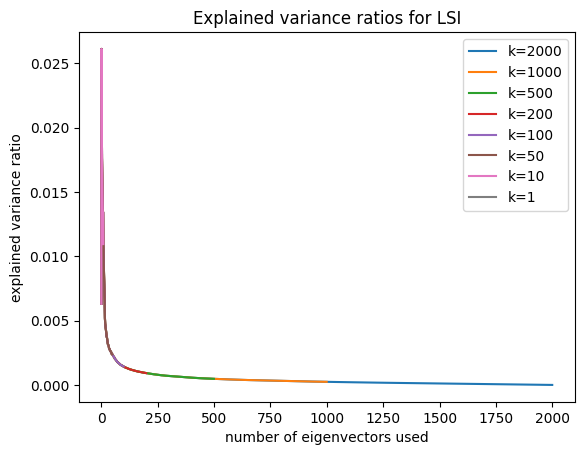

In [19]:
# Plot explained variance ratios
for r in reversed(variance_ratios):
    k = len(r)
    plt.plot(r, label=f'k={k}')
plt.legend()
plt.xlabel('number of eigenvectors used')
plt.ylabel('explained variance ratio')
plt.title('Explained variance ratios for LSI')
plt.show()

This plot depicts how much each eigenvector can explain the variance of our data. As we order by eigenvalue (or rather, the derived variance ratio), we have our most significant variances on the right and least significant on the left. What the shape of the plot tells us is that there is a diminishing relevance with each additional eigenvector. It also shows roughly how many eigenvectors we need to characterise the data. Based on the plot,this appears to be somewhere in $50 \leq k \leq 100$.

In [ ]:
## 4.2 - LSI Explained variance ratios


In [ ]:
lsi_handler, train_lsi, test_lsi = reduce_dim_lsi(k=50)
nmf_handler, reduce_dim_nmf(k=50)

In [1]:
# TODO delete this
from numpy import array
from numpy import mean
from numpy import cov
from numpy.linalg import eig

# define a matrix
A = array([[1, 2], [3, 4], [5, 6]])
print(A)
# calculate the mean of each column
M = mean(A.T, axis=1)
print(M)
# center columns by subtracting column means
C = A - M
print(C)
# calculate covariance matrix of centered matrix
V = cov(C.T)
print(V)
# eigendecomposition of covariance matrix
values, vectors = eig(V)
print(vectors)
print(values)
# project data
P = vectors.T.dot(C.T)
print(P.T)

[[1 2]
 [3 4]
 [5 6]]
[3. 4.]
[[-2. -2.]
 [ 0.  0.]
 [ 2.  2.]]
[[4. 4.]
 [4. 4.]]
[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]
[8. 0.]
[[-2.82842712  0.        ]
 [ 0.          0.        ]
 [ 2.82842712  0.        ]]
